In [2]:
!gdown 1fChs4E75w4mBOh-yVP652dmlVpy2bqMN

Downloading...
From (original): https://drive.google.com/uc?id=1fChs4E75w4mBOh-yVP652dmlVpy2bqMN
From (redirected): https://drive.google.com/uc?id=1fChs4E75w4mBOh-yVP652dmlVpy2bqMN&confirm=t&uuid=8a516a19-90ab-41d3-b16e-378c2cd5a040
To: /content/leaf_disease.zip
100% 528M/528M [00:04<00:00, 132MB/s]


In [4]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/leaf_disease.zip'

# Directory to extract to
extract_dir = '/content/extracted_files'

# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")


Extraction complete.


# LEAF DISEASE SEGMENTATION

# Importing Dependancies

In [ ]:
import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
import cv2
from mpl_toolkits.mplot3d import Axes3D


# Data Separation

In [ ]:
image_source_dir = "/content/extracted_files/leaf_disease_segmentation/aug_data/train_images"
mask_source_dir = "/content/extracted_files/leaf_disease_segmentation/aug_data/train_masks"

# Destination directories for train and val
train_image_dir = "/content/working/image/img"
train_mask_dir = "/content/working/mask/img"
test_image_dir = "/content/working/image/img"

# Create train and val directories
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)

os.makedirs(test_image_dir, exist_ok=True)

# List all image and mask files
image_files = os.listdir(image_source_dir)
mask_files = os.listdir(mask_source_dir)

# Set the proportion of data to be used for validation
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files)-num_validation_samples

# Randomly shuffle the list of files
random.shuffle(image_files)

# Move files to train and val directories
for i, image_file in enumerate(image_files):
    source_image_path = os.path.join(image_source_dir, image_file)
    source_mask_file = os.path.splitext(image_file)[0] + ".png"
    source_mask_path = os.path.join(mask_source_dir, source_mask_file)
    shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
    shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))

random.shuffle(image_files)

for i, image_file in enumerate(image_files):
    source_image_path = os.path.join(image_source_dir, image_file)
    shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))

print("Data separation complete.")

Data separation complete.


# Visualizing the Data

/content/working/image/img/00532_2.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


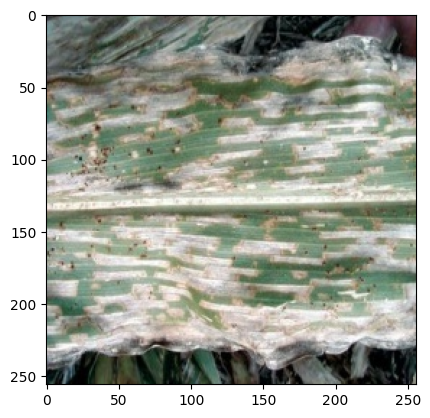

/content/working/mask/img/00532_2.png
(256, 256)


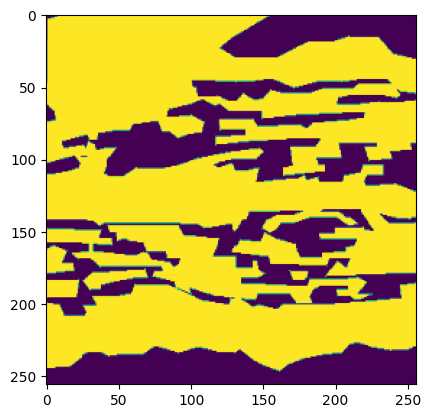

----------------------------------------------------
/content/working/image/img/00552_3.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


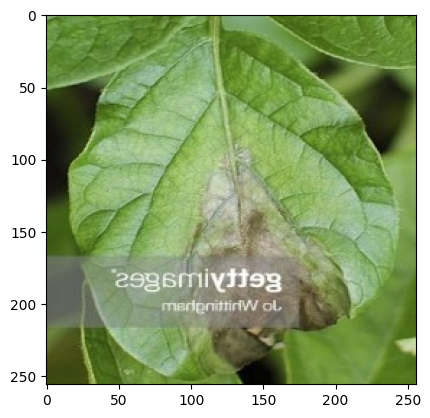

/content/working/mask/img/00552_3.png
(256, 256)


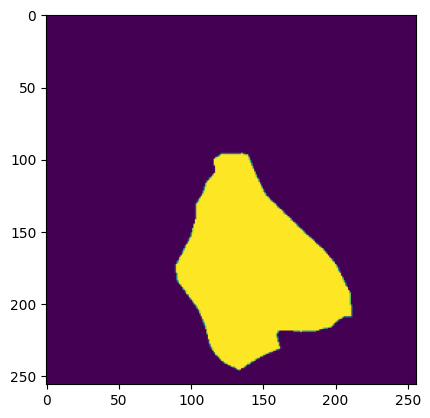

----------------------------------------------------
/content/working/image/img/00501_4.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


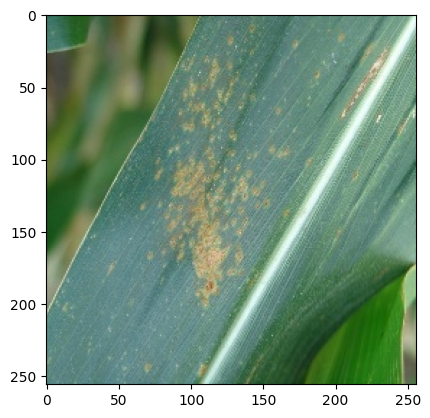

/content/working/mask/img/00501_4.png
(256, 256)


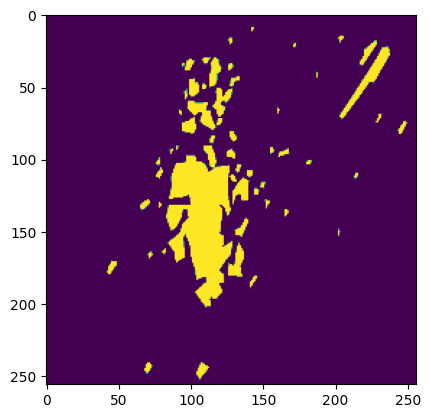

----------------------------------------------------


In [ ]:
def show_images(loops=1):
    for i in range(loops):
        img_path = os.path.join(train_image_dir, image_files[i])
        source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
        mask_path = os.path.join(train_mask_dir, source_mask_file)
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(3)

# Resizing the images and the masks

In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3



X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


print('Resizing training images and masks')
for i in tqdm(range(num_train_samples), desc='Processing images'):
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)

    img = Image.open(img_path)
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[i] = mask


X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    img_path = os.path.join(test_image_dir, image_files[i])
    img = Image.open(img_path)
    img = np.array(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img


Resizing training images and masks


Processing images: 100%|██████████| 2000/2000 [06:28<00:00,  5.15it/s]


Resizing test images


Processing images: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]


# Images after resizing

(128, 128, 3)


/tmp/ipython-input-98-1969987430.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[image_x])


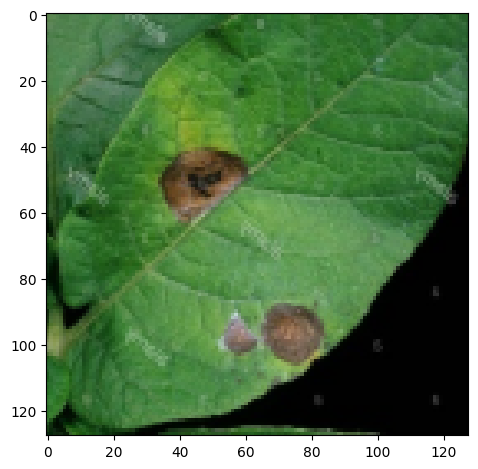

/tmp/ipython-input-98-1969987430.py:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[image_x]))


(128, 128, 1)


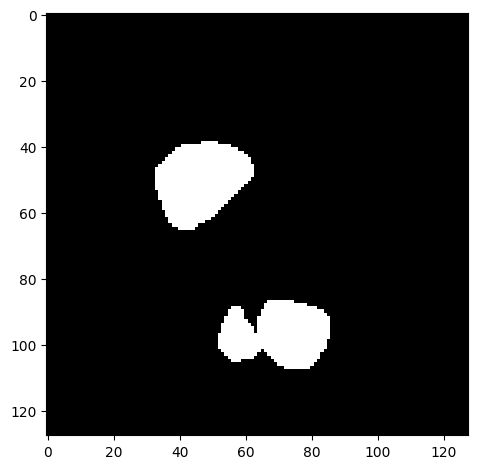

In [ ]:

image_x = 6
imshow(X_train[image_x])
print(X_train[image_x].shape)
plt.show()
imshow(np.squeeze(Y_train[image_x]))
print(Y_train[image_x].shape)
plt.show()


# Model Trainning

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)


In [ ]:
model = Sequential()
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_7[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 128, 128,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_44[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 64, 64,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_14… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv2d_46[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 32, 32,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv2d_48[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 16,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv2d_50[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_12[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8499 - loss: 0.3475 - val_accuracy: 0.8638 - val_loss: 0.3317
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8596 - loss: 0.3286 - val_accuracy: 0.8714 - val_loss: 0.3077
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8670 - loss: 0.3120 - val_accuracy: 0.8797 - val_loss: 0.2933
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8668 - loss: 0.3132 - val_accuracy: 0.8732 - val_loss: 0.3083
Epoch 5/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8694 - loss: 0.3042 - val_accuracy: 0.8774 - val_loss: 0.2921
Epoch 6/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8778 - loss: 0.2899 - val_accuracy: 0.8864 - val_loss: 0.2788
Epoch 7/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8802 - loss: 0.2858 - val_accuracy: 0.8899 - val_loss: 0.2735
Epoch 8/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8840 - loss: 0.2758 - val_accu

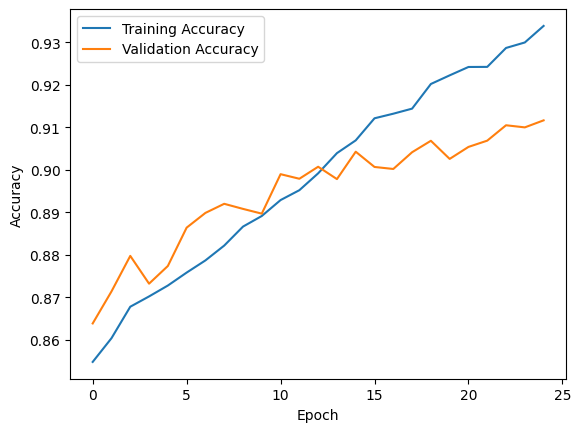

In [ ]:
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
mymodel = history.history['accuracy'][-1]
mymodel

0.933867871761322

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/tmp/ipython-input-101-251096792.py:11: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])


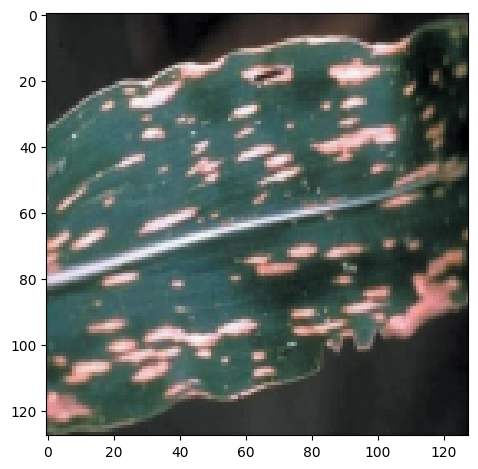

/tmp/ipython-input-101-251096792.py:13: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[ix]))


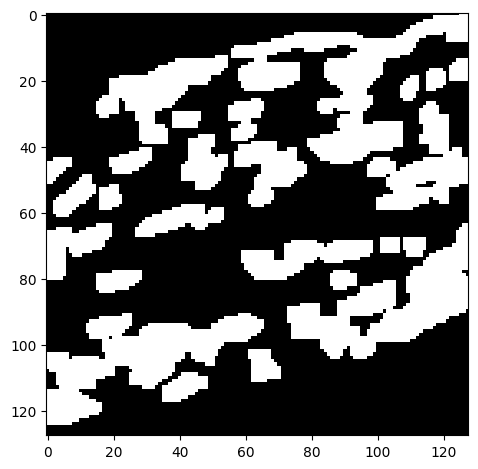

/tmp/ipython-input-101-251096792.py:15: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_train_t[ix]))
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


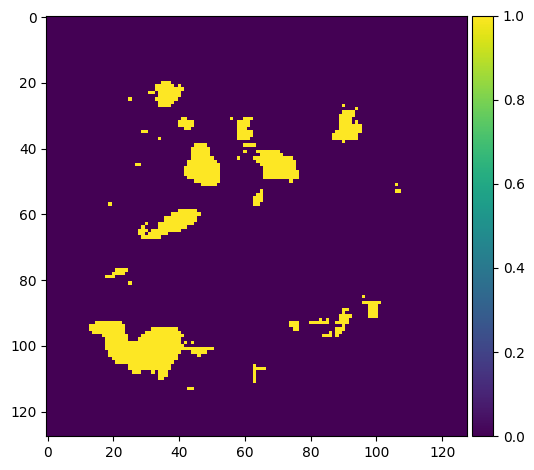

/tmp/ipython-input-101-251096792.py:20: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[int(X_train.shape[0]*0.9):][ix])


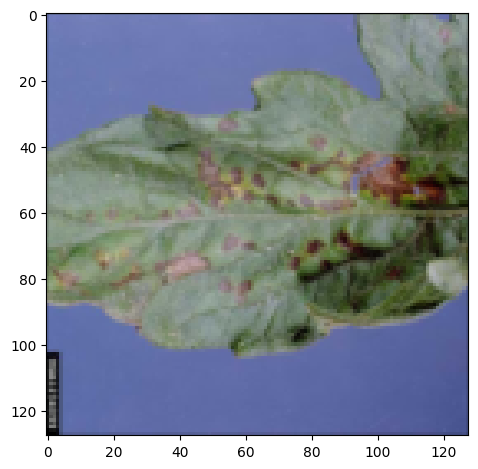

/tmp/ipython-input-101-251096792.py:22: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))


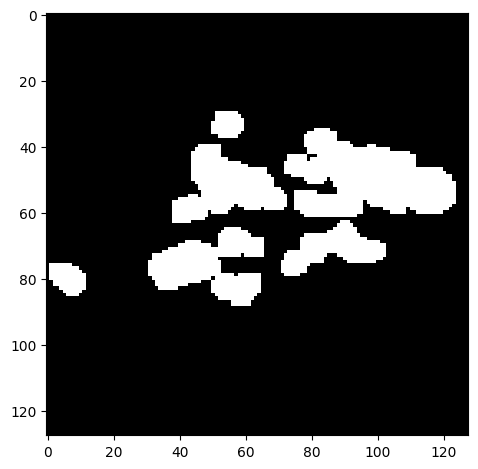

/tmp/ipython-input-101-251096792.py:24: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_val_t[ix]))
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


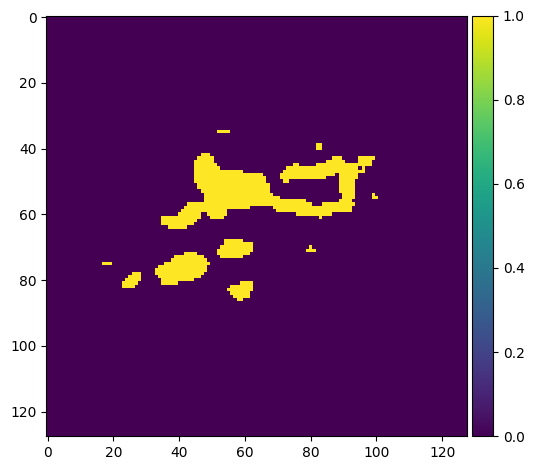

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()